In [1]:
# Importing basic libraries 
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import random 
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# Loading the dataset CSV files
train = pd.read_csv('/kaggle/input/aptos2019-blindness-detection/train.csv')

In [3]:
# Displaying number of samples
print('Number of train samples: ', train.shape[0])

Number of train samples:  3662


In [4]:
print("\nTrain dataset info:")
train.info()


Train dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3662 entries, 0 to 3661
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id_code    3662 non-null   object
 1   diagnosis  3662 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 57.3+ KB


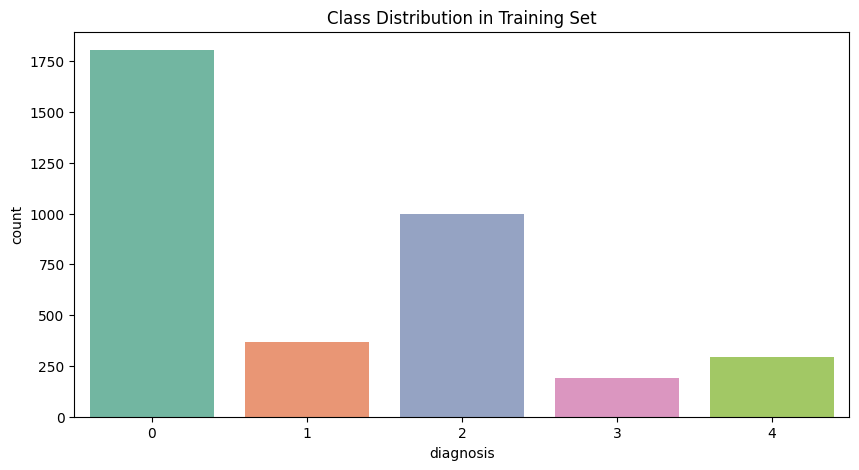

In [5]:
# class distribution in the training set
f, ax = plt.subplots(figsize=(10, 5))
ax = sns.countplot(x="diagnosis", data=train, palette="Set2")
plt.title("Class Distribution in Training Set")
plt.show()